In [4]:
pip install PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 50.6 MB/s eta 0:00:00


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Pdf_2.pdf to Pdf_2.pdf


In [6]:
import fitz  # PyMuPDF
import os

# Path to the PDF file you want to convert
pdf_file = '/content/Pdf_2.pdf'

# Specify the output directory where the images will be saved
output_dir = '/content/output_directory/'  # Note the /content/ prefix

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set the resolution (increase the values for higher resolution)
xres, yres = 600, 600  # You can adjust these values

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page in the PDF
for page_number in range(len(pdf_document)):
    page = pdf_document.load_page(page_number)
    image = page.get_pixmap(matrix=fitz.Matrix(xres/72, yres/72))
    image.save(os.path.join(output_dir, f'page_{page_number + 1}.png'))

# Close the PDF file
pdf_document.close()


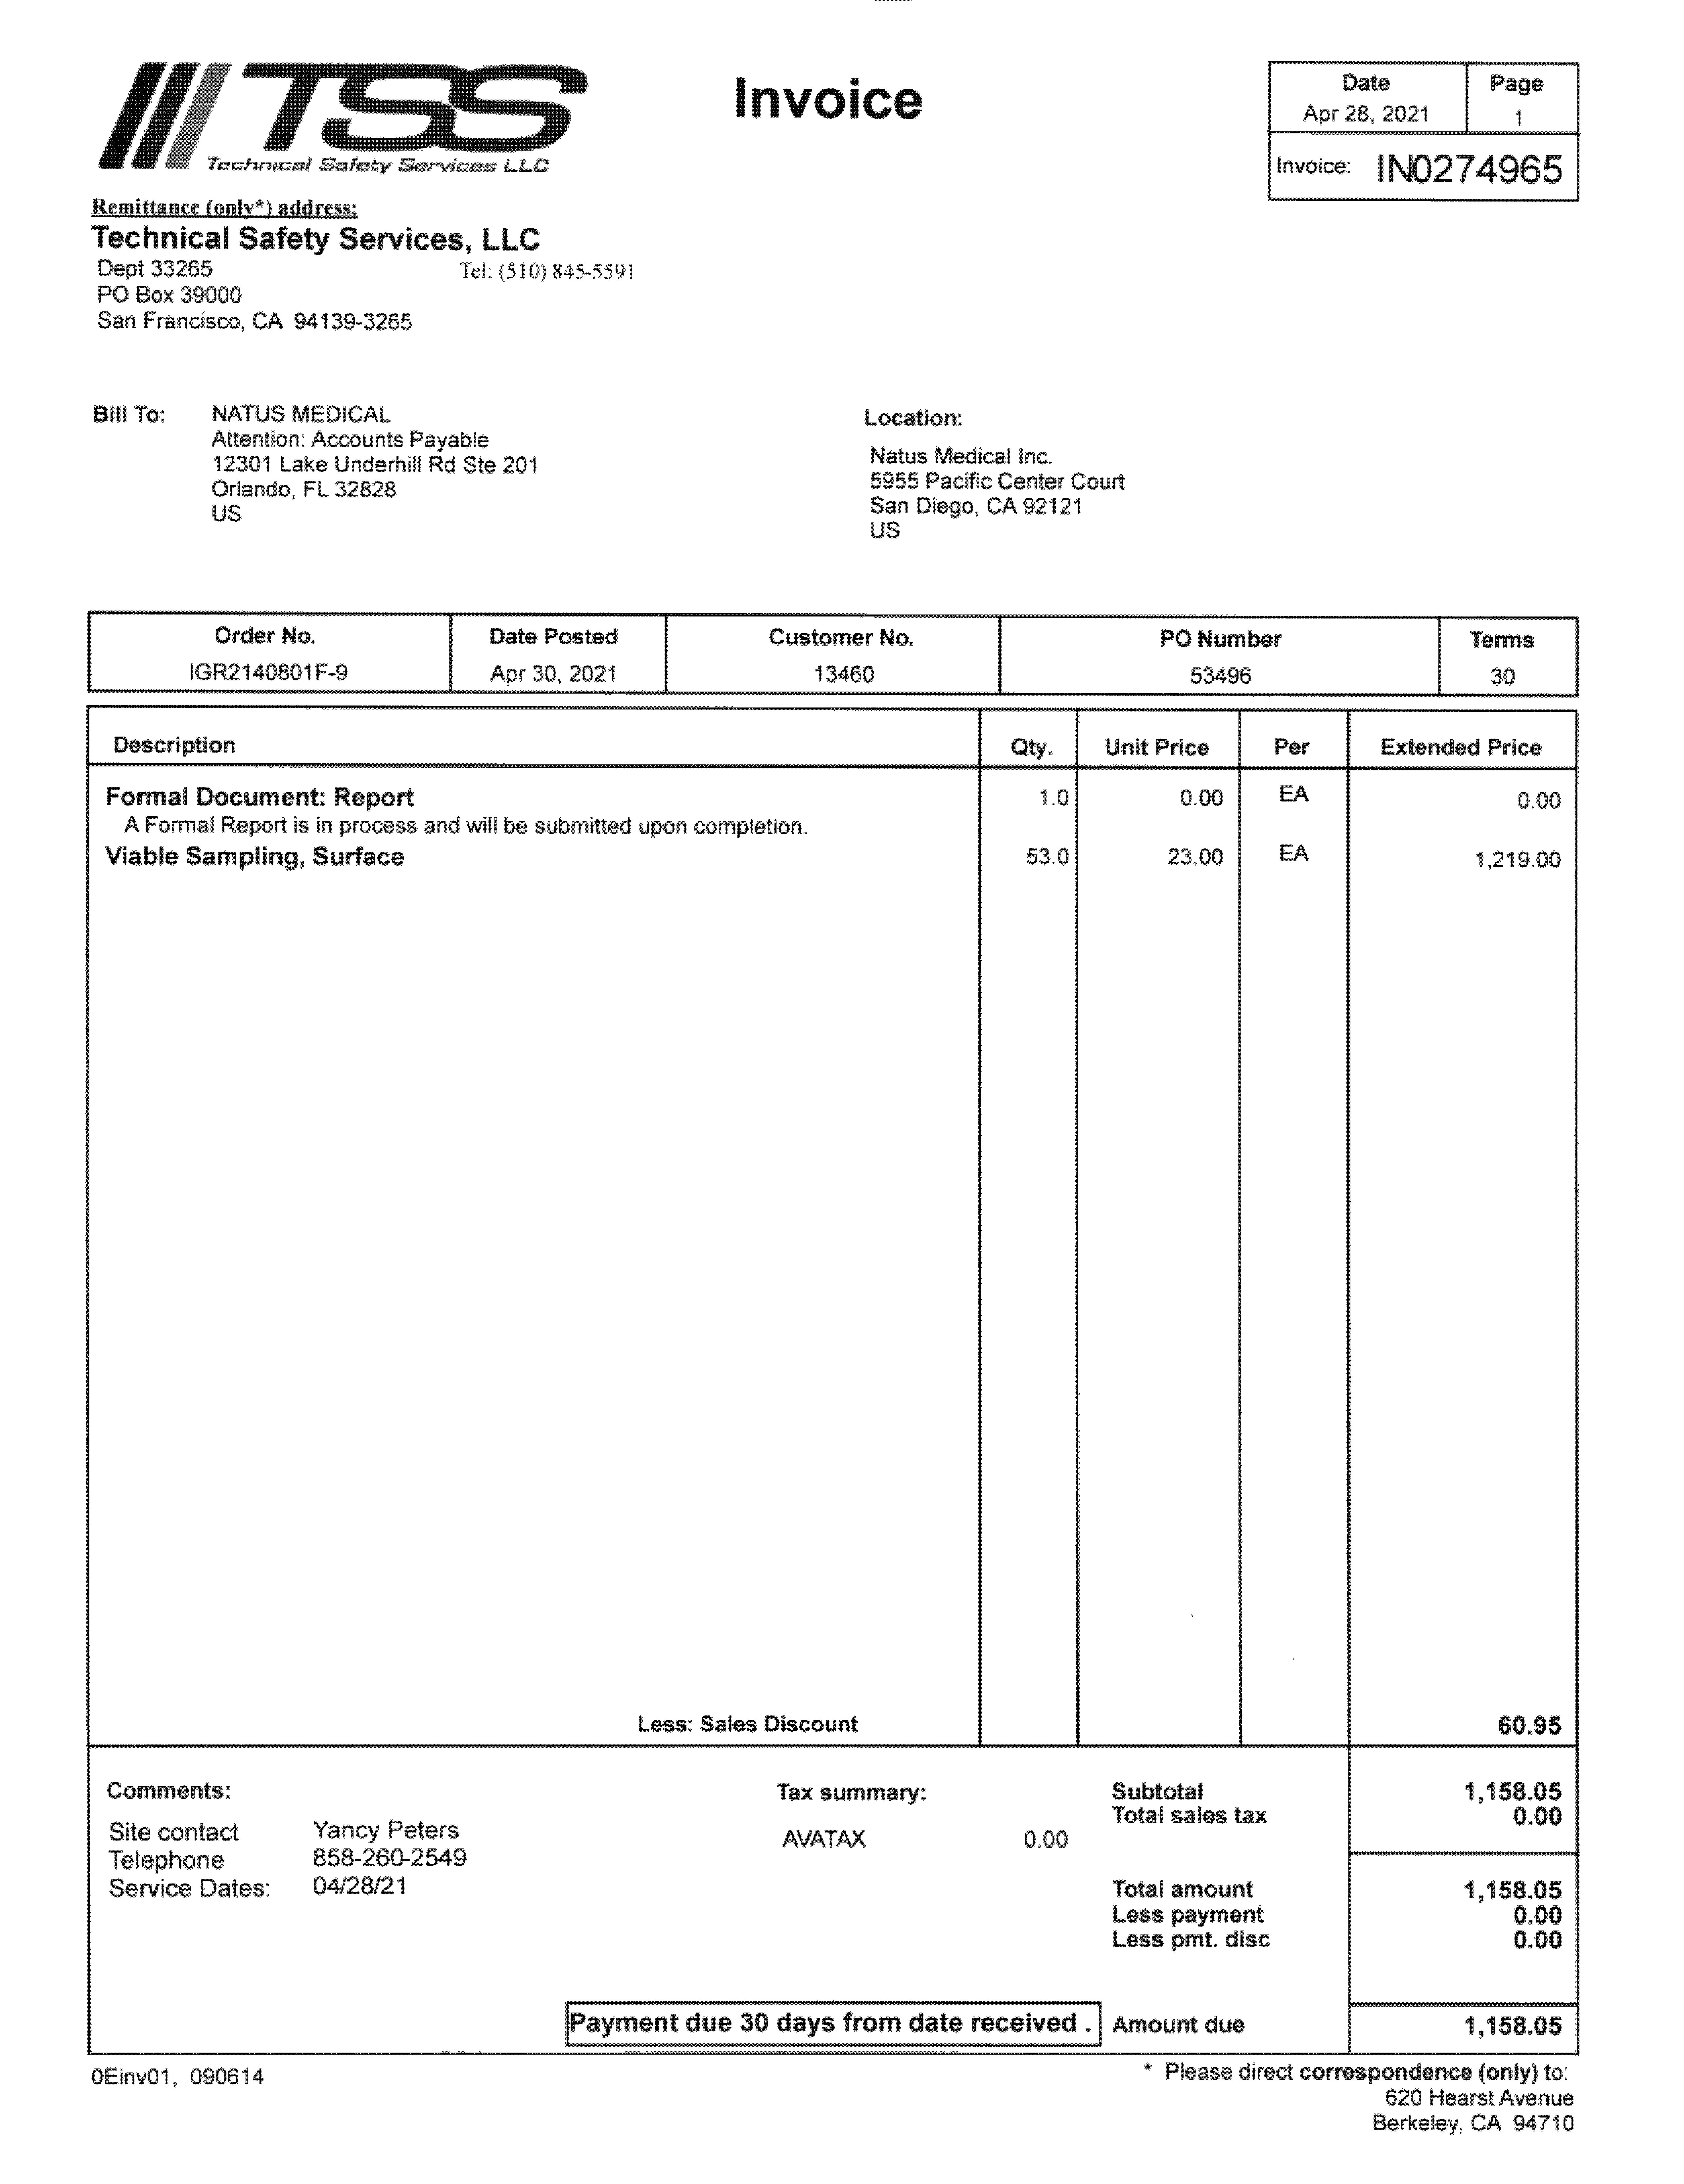

In [7]:
import cv2
from google.colab.patches import cv2_imshow
image=cv2.imread('/content/output_directory/page_1.png')
cv2_imshow(image)

In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Your class definition goes here
class ImageProcessor:
    def __init__(self, image_path):
        self.image = cv2.imread(image_path)
        self.grayscale_image = None
        self.thresholded_image = None
        self.inverted_image = None
        self.dilated_image = None
        self.contours = None


    def convert_image_to_grayscale(self):
        self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def threshold_image(self):
        self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    def invert_image(self):
        self.inverted_image = cv2.bitwise_not(self.thresholded_image)

    def dilate_image(self):
        self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=5)

    def find_contours(self):
        self.contours, self.hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Below lines are added to show all contours
        # This is not needed, but it is useful for debugging
        self.image_with_all_contours = self.image.copy()
        cv2.drawContours(self.image_with_all_contours, self.contours, -1, (0, 255, 0), 3)

    def filter_contours_and_leave_only_rectangles(self):
        self.rectangular_contours = []
        for contour in self.contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
            if len(approx) == 4:
                self.rectangular_contours.append(approx)
        # Below lines are added to show all rectangular contours
        # This is not needed, but it is useful for debugging
        self.image_with_only_rectangular_contours = self.image.copy()
        cv2.drawContours(self.image_with_only_rectangular_contours, self.rectangular_contours, -1, (0, 255, 0), 3)
        return self.image_with_only_rectangular_contours

    def find_largest_contour_by_area(self):
        max_area = 0
        self.contour_with_max_area = None
        for contour in self.rectangular_contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                self.contour_with_max_area = contour
        # Below lines are added to show the contour with max area
        # This is not needed, but it is useful for debugging
        self.image_with_contour_with_max_area = self.image.copy()
        cv2.drawContours(self.image_with_contour_with_max_area, [self.contour_with_max_area], -1, (0, 255, 0), 3)

    def order_points_in_the_contour_with_max_area(self):
        self.contour_with_max_area_ordered = self.order_points(self.contour_with_max_area)
        # The code below is to plot the points on the image
        # it is not required for the perspective transform
        # it will help you to understand and debug the code
        self.image_with_points_plotted = self.image.copy()
        for point in self.contour_with_max_area_ordered:
            point_coordinates = (int(point[0]), int(point[1]))
            self.image_with_points_plotted = cv2.circle(self.image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)

    def calculate_new_width_and_height_of_image(self):
        existing_image_width = self.image.shape[1]
        existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)

        distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[1])
        distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(self.contour_with_max_area_ordered[0], self.contour_with_max_area_ordered[3])
        aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
        self.new_image_width = existing_image_width_reduced_by_10_percent
        self.new_image_height = int(self.new_image_width * aspect_ratio)

    def apply_perspective_transform(self):
        pts1 = np.float32(self.contour_with_max_area_ordered)
        pts2 = np.float32([[0, 0], [self.new_image_width, 0], [self.new_image_width, self.new_image_height], [0, self.new_image_height]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.perspective_corrected_image = cv2.warpPerspective(self.image, matrix, (self.new_image_width, self.new_image_height))

    def calculateDistanceBetween2Points(self, p1, p2):
        dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
        return dis

    def order_points(self, pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def add_10_percent_padding(self):
        image_height = self.perspective_corrected_image.shape[0]
        padding = int(image_height * 0.1)
        self.perspective_corrected_image_with_padding = cv2.copyMakeBorder(self.perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        # Apply additional processing to the padded image

    def save_perspective_corrected_image(self, output_path):
        cv2.imwrite(output_path, self.perspective_corrected_image_with_padding)

# Create an instance of ImageProcessor
image_processor = ImageProcessor('/content/output_directory/page_1.png')

# Process the image and find contours
image_processor.convert_image_to_grayscale()
image_processor.threshold_image()
image_processor.invert_image()
image_processor.dilate_image()
image_processor.find_contours()
image_processor.filter_contours_and_leave_only_rectangles()
image_processor.find_largest_contour_by_area()
image_processor.order_points_in_the_contour_with_max_area()
image_processor.calculate_new_width_and_height_of_image()
image_processor.apply_perspective_transform()
image_processor.add_10_percent_padding()



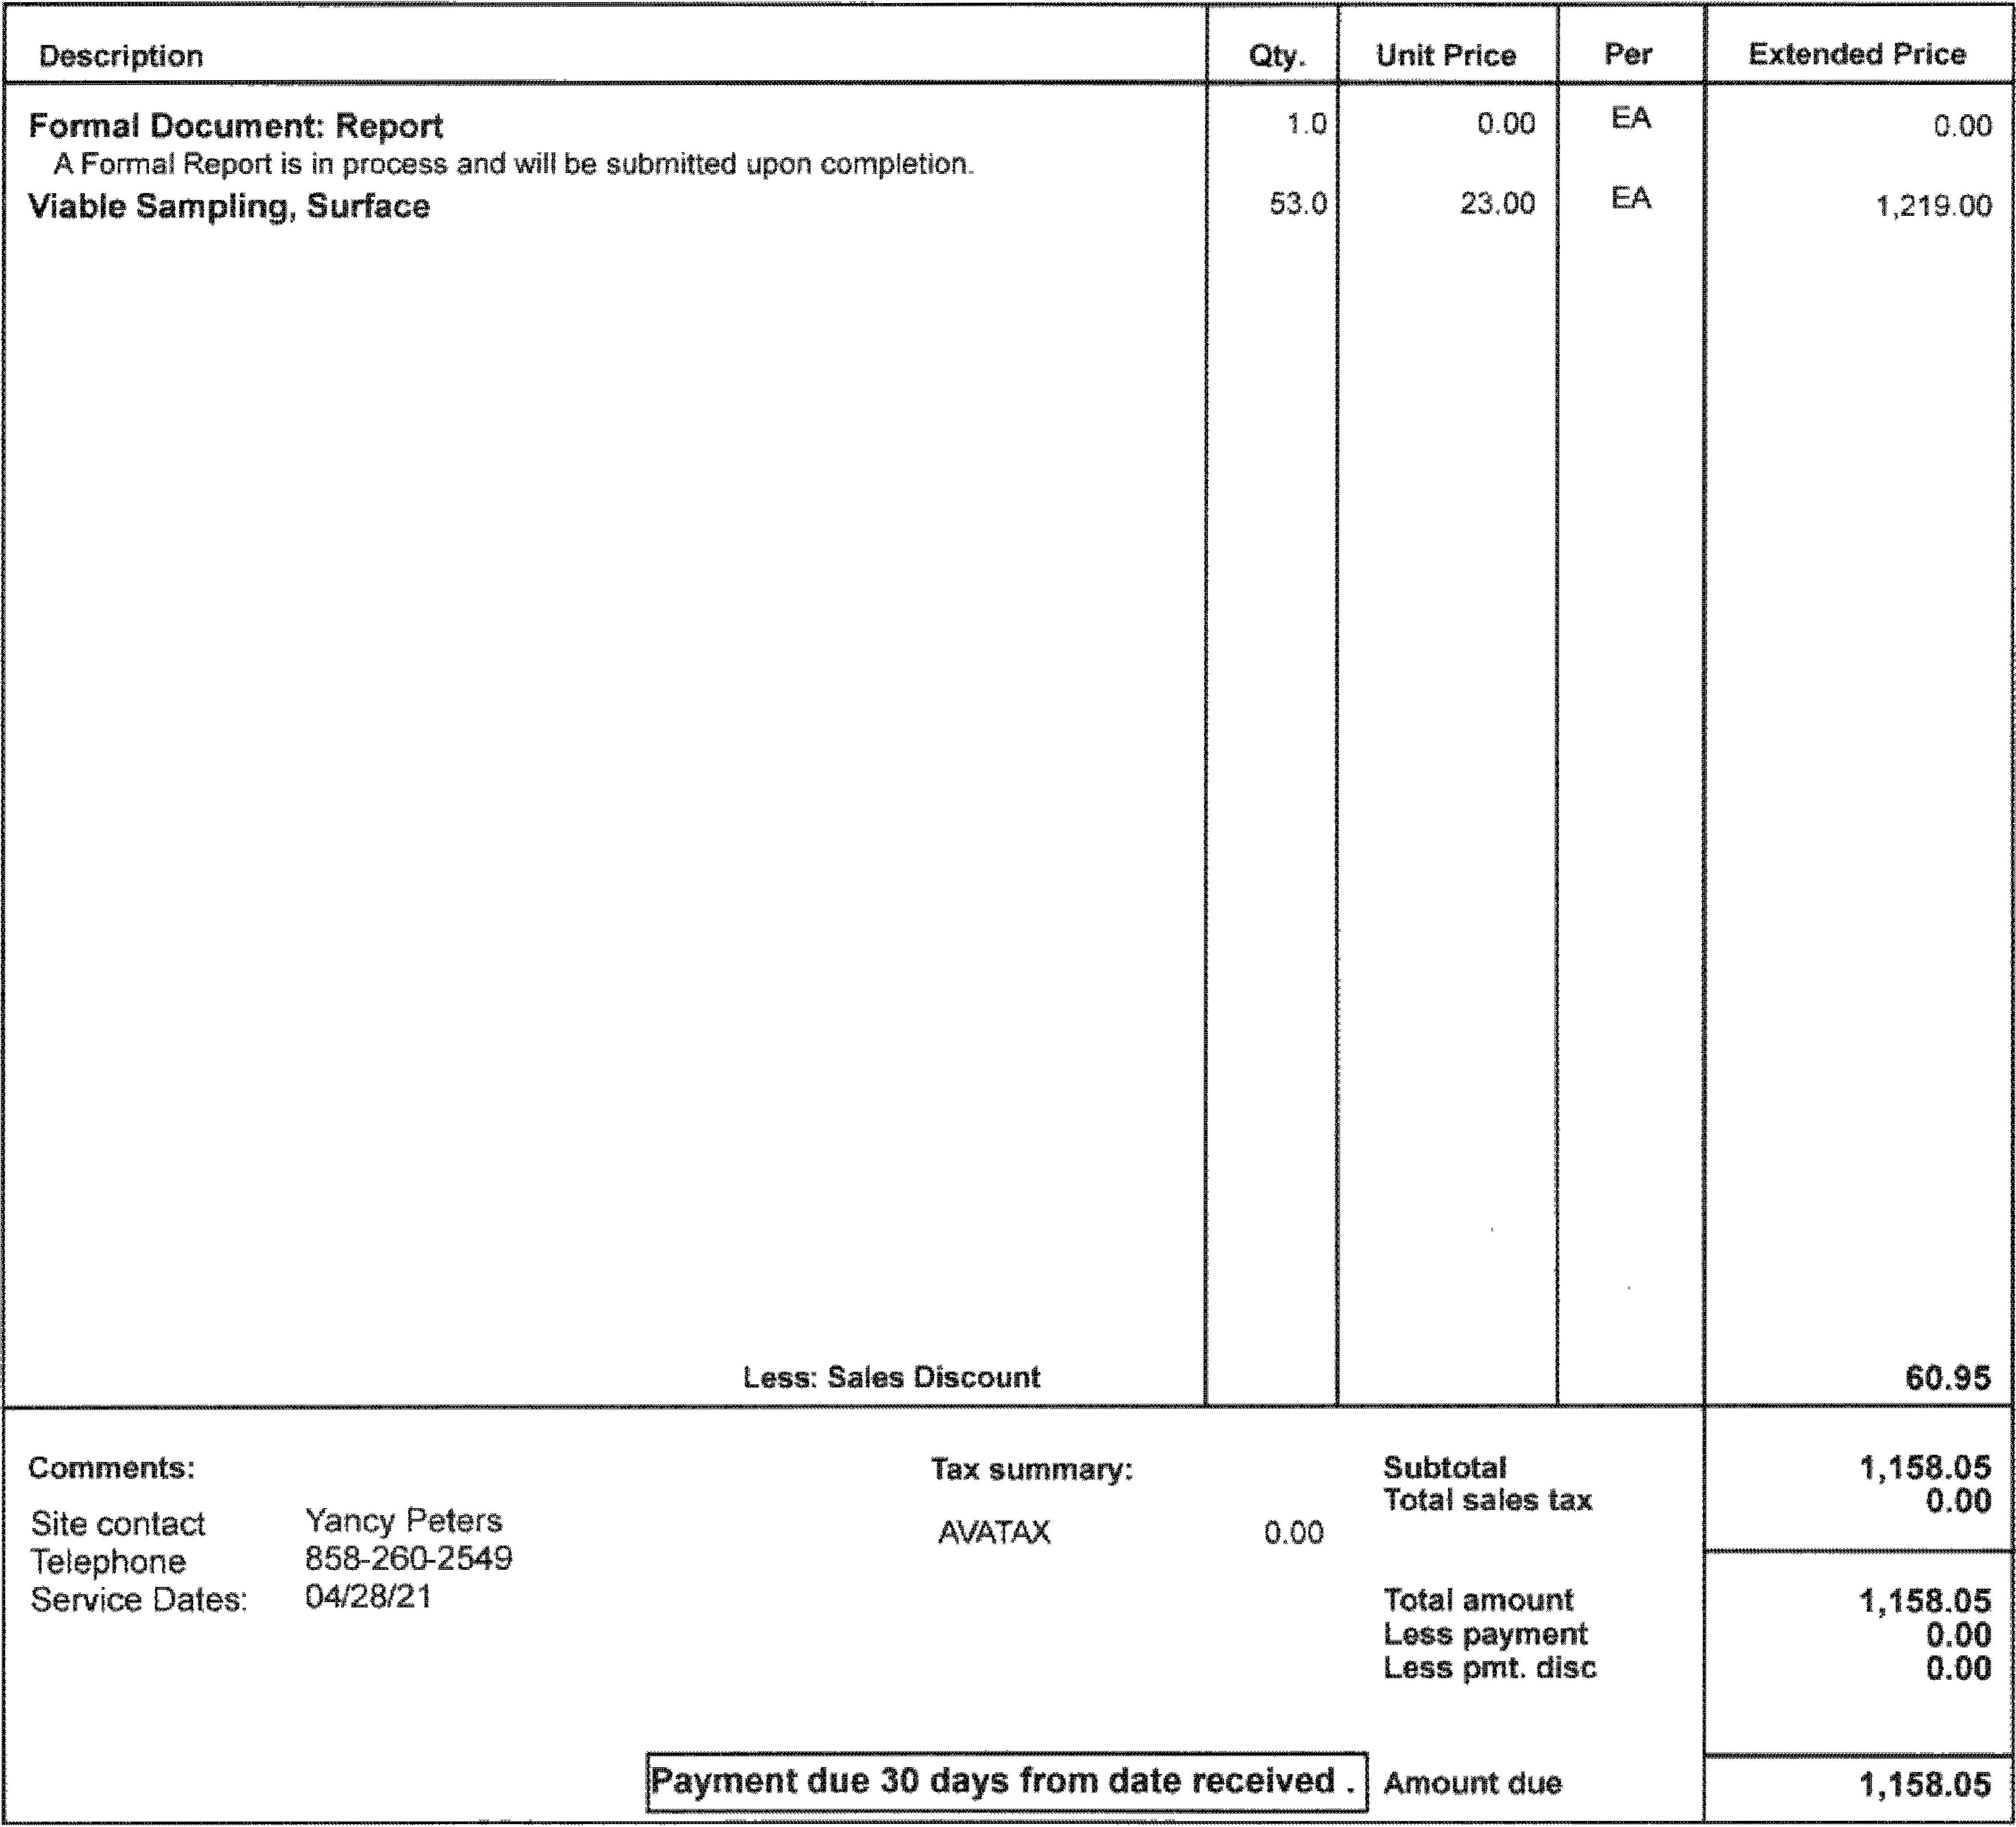

-1

In [9]:
cv2_imshow( image_processor.perspective_corrected_image)
cv2.waitKey(0)

In [10]:
output_file = '/content/output_directory/First iteration Pdf_2.png'
image_processor.save_perspective_corrected_image(output_file)

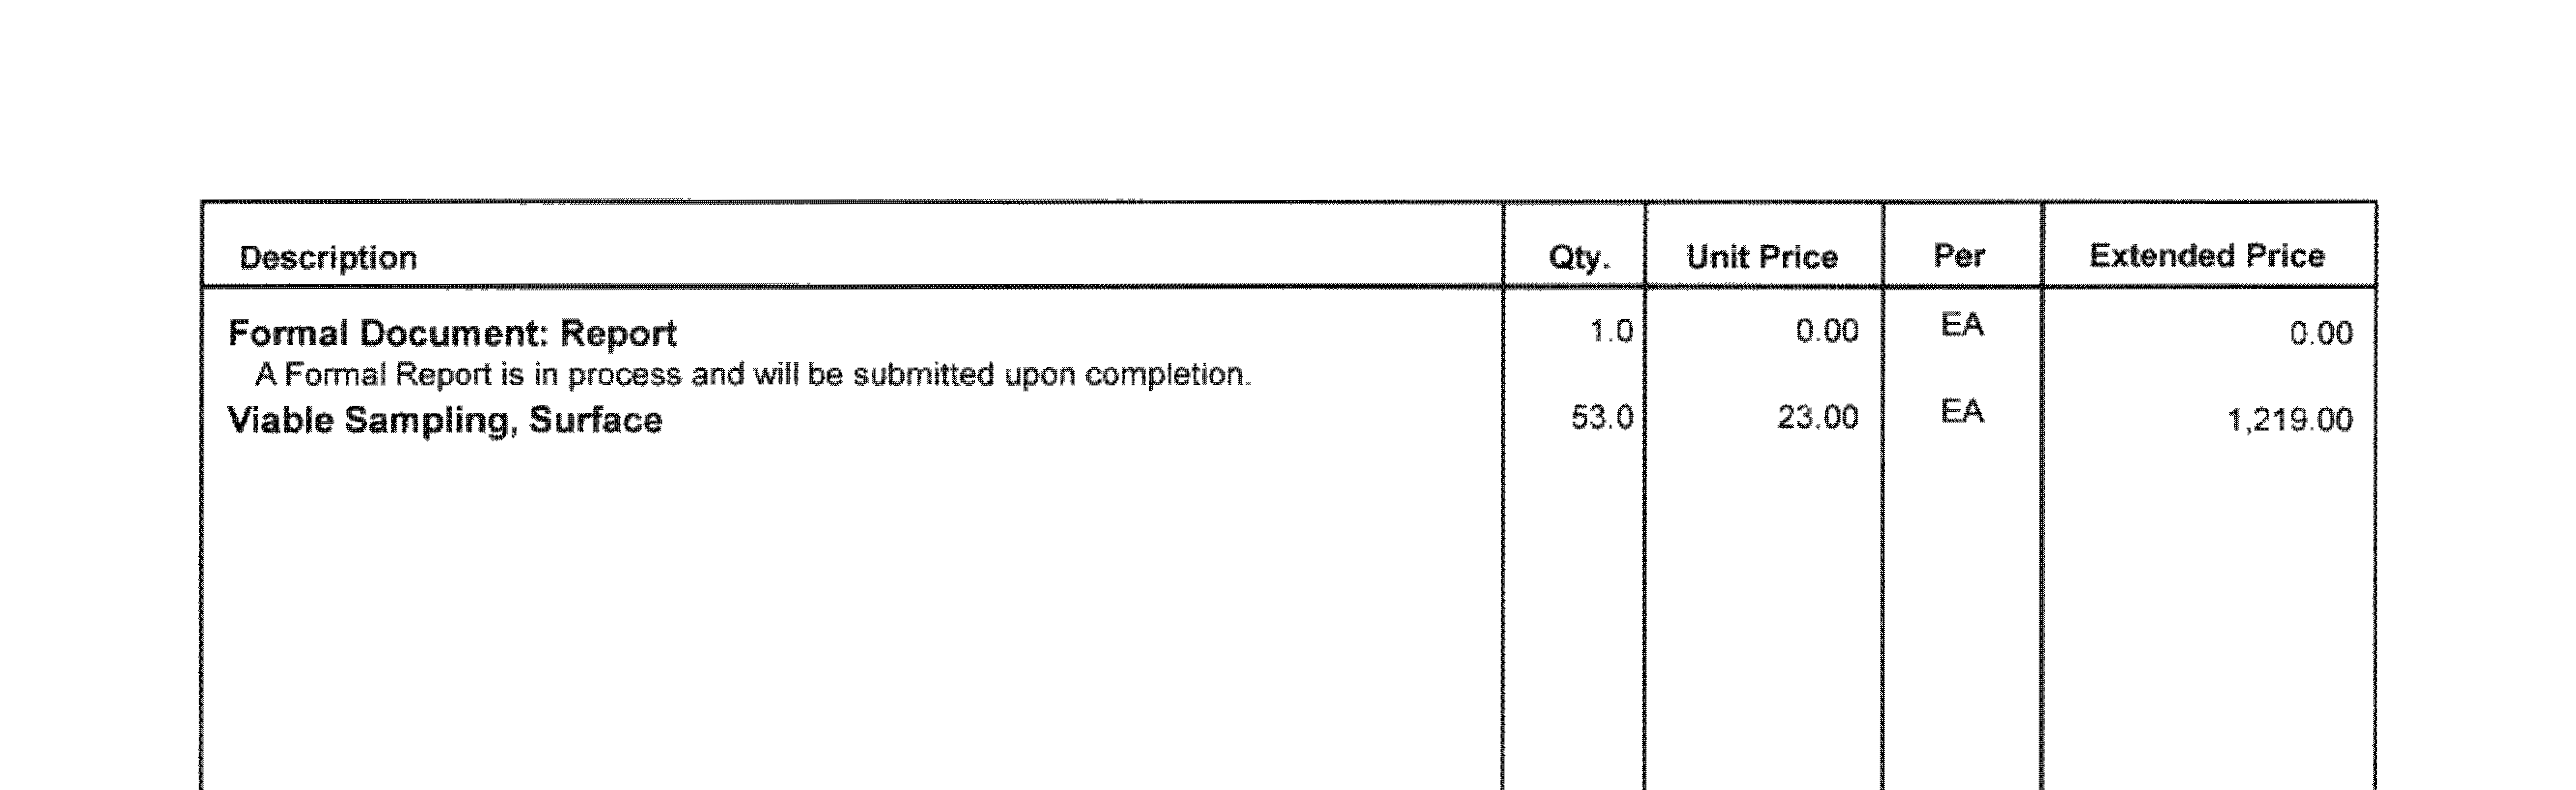

In [11]:
import cv2
import numpy as np

def extract_top_half_of_table(input_image_path, output_image_path):
    # Read the input image
    image = cv2.imread(input_image_path)

    # Calculate the dimensions of the top half of the image
    height, width, _ = image.shape
    top_half_height = height // 3

    # Extract the top half of the image
    top_half_image = image[:top_half_height, :]

    # Save the top half of the image to the output file
    cv2.imwrite(output_image_path, top_half_image)

# Input and output file paths
input_image_path = '/content/output_directory/First iteration Pdf_2.png'
output_image_path = '/content/output_directory/Second iteration Pdf_2.png'

# Extract the top half of the table from the input image
extract_top_half_of_table(input_image_path, output_image_path)

# Display the top half of the table
cv2_imshow(cv2.imread(output_image_path))
cv2.waitKey(0)
cv2.destroyAllWindows()


In [12]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (7,922 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [13]:
!pip install pytesseract

In [14]:
import pytesseract
import cv2
from google.colab.patches import cv2_imshow

#Load the image using OpenCV
image = cv2.imread('/content/output_directory/Second iteration Pdf_2.png') # Update the path to your image

#Define xres and yres
xres, yres = 4400, 2000 # Set your desired xres and yres values
image = cv2.resize(image, (xres, yres))
text = pytesseract.image_to_string(image, lang='eng')
print(text)


          

Description . | nit Price | Extended Price

Formal Document: Report 1.0) 0.00 | 0.00,

A Formal Report is in process and will be submitted upon completion. | | |
| Viable Sampling, Surface | 63.0 23.00

SS]

1,219.00,



In [16]:
import re
import pandas as pd

# First code snippet
summary = text

# Define the regex pattern for the first code snippet
pattern = r'Formal Document: Report 1\.0\) 0\.00 \| 0\.00,'

# Use re.search to find the pattern in the summary
match = re.search(pattern, summary)

if match:
    result = match.group()

    # Create a DataFrame with the extracted data from the first code snippet
    data = {
        'Description': ['Formal Document: Report'],
        'Qty': ['1.0'],
        'Unit Price': ['0.00'],
        'Extended Price': ['0.00'],
    }

    df = pd.DataFrame(data)
else:
    df = pd.DataFrame()

# Second code snippet
data = text

# Define the regular expression pattern to extract the extended price
extended_price_pattern = r"(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)"
extended_price_matches = re.findall(extended_price_pattern, data)

if extended_price_matches:
    extended_price = extended_price_matches[-1]
else:
    extended_price = ''

# Create a DataFrame for the data from the second code snippet
matches = re.findall(r'\|[^|]+\|([^|]+)\| ([\d.]+) ([\d.]+)', data)
df2 = pd.DataFrame(matches, columns=['Description', 'Qty', 'Unit Price'])

# Add the Extended Price column
df2['Extended Price'] = extended_price

# Append the data from the second code snippet to the first DataFrame
df = df.append(df2, ignore_index=True)

# Print the combined DataFrame
print(df)


                  Description   Qty Unit Price Extended Price
0     Formal Document: Report   1.0       0.00           0.00
1   Viable Sampling, Surface   63.0      23.00       1,219.00


<ipython-input-16-95487e1ec63a>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index=True)
